# **TDP Week 3** - Electric Probes

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sdas.tests.LoadSdasData import LoadSdasData
from sdas.tests.StartSdas import StartSdas

plt.style.use('bmh')

## **$1^{st}$ Part:**

Effect of the cut-off voltage on the estimated plasma parameters (particularly on the
electron temperature and fit quality)
for one I-V characteristic showing a deviation from
the exponential behaviour (data in table 1) [Note: I will consider 3 to 4 I-V characteristic curves.]

<center>

|shot ID|collected current ID|applied voltage|
|-----|-----------|-----------|
|35605|CHANNEL_030|CHANNEL_026|
|36892|CHANNEL_028|CHANNEL_029|
|36892|CHANNEL_026|CHANNEL_029|

**Table 1:** Data for the cut-off voltage analysis.

</center>

**Note:** The units of the signals are: Time ($\mu s$), Collected current (mA) and Applied voltage (V). 

In [3]:
# Load and select data
shot = 35605
client = StartSdas()
V_data, time = LoadSdasData(client, 'PCIE_ATCA_ADC_16.BOARD_1.CHANNEL_026', shot)
I_data, _ = LoadSdasData(client, 'PCIE_ATCA_ADC_16.BOARD_1.CHANNEL_030', shot)

In [4]:
def color_title(labels, colors, textprops ={'size':'large'}, ax = None, y = 1.033,
               precision = 10**-2):
     
    "Creates a centered title with multiple colors."
        
    if ax == None:
        ax = plt.gca()
        
    plt.gcf().canvas.draw()
    transform = ax.transAxes # use axes coords
    
    # initial params
    xT = 0 # where the text ends in x-axis coords
    shift = 0 # where the text starts
    
    # for text objects
    text = dict()

    while (np.abs(shift - (1-xT)) > precision) and (shift <= xT) :         
        x_pos = shift 
        
        for label, col in zip(labels, colors):

            try:
                text[label].remove()
            except KeyError:
                pass
            
            text[label] = ax.text(x_pos, y, label, 
                        transform = transform, 
                        ha = 'left',
                        color = col,
                        **textprops)
            
            x_pos = text[label].get_window_extent()\
                   .transformed(transform.inverted()).x1
            
        xT = x_pos # where all text ends
        
        shift += precision/2 # increase for next iteration
      
        if x_pos > 1: # guardrail 
            break

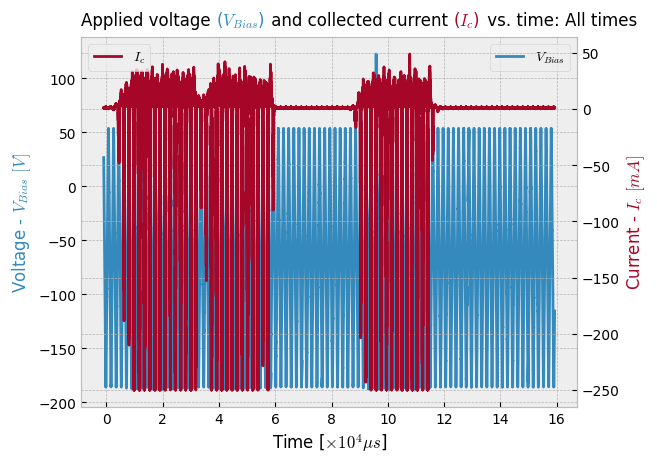

<Figure size 640x480 with 0 Axes>

In [5]:
# "Interactive" plots: Change 'inline' to 'widget'
%matplotlib inline

# Getting to know our data:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(time*1e-4, V_data, 'C0-', label=r'$V_{Bias}$')
ax2.plot(time*1e-4, I_data, 'C1-', label=r'$I_c$')

ax1.set_xlabel(r'Time [$\times 10^{4}\mu s$]')
ax1.set_ylabel(r'Voltage - $V_{Bias}$ $[V]$', color='C0')
ax2.set_ylabel(r'Current - $I_c$ $[mA]$', color='C1')

label_list = ['Applied voltage ', r'($V_{Bias}$) ', ' and collected current ', r'($I_c$) ', ' vs. time: All times']
colors = ['black', 'C0', 'black', 'C1', 'black']
color_title(label_list, colors)

plt.grid(True)
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
# plt.savefig('TestFig1.svg', format = 'svg')
plt.show()
plt.clf()
# plt.close() # Useful when dealing with widgets...
# Here, the 3 cycles are visible.

In [6]:
# Selecting a time interval:
bool_indices = (time > 50500) & (time < 53900) # Considering 2 I-V curves, in the 2nd cycle.
V_data_d = V_data[bool_indices]
I_data_d = I_data[bool_indices]
time_d = time[bool_indices]

In [7]:
# Debugging stuff: First few times are negative? Times before discharge?
# print(bool_indices)
# print(V_data_d)
# print(I_data_d)
# print(time_d)

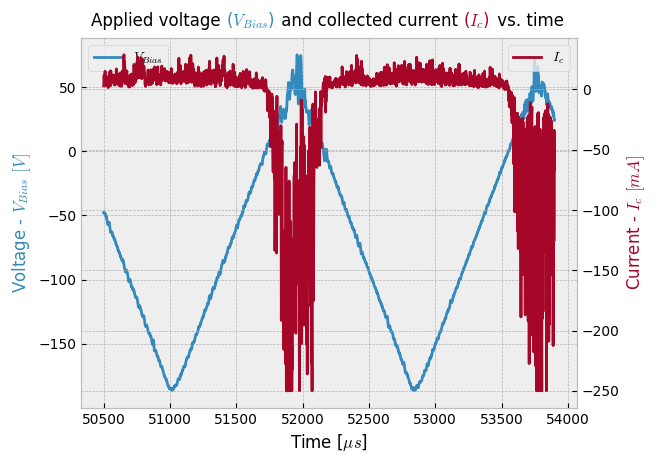

<Figure size 640x480 with 0 Axes>

In [8]:
# Plotting the selected time interval:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(time_d, V_data_d, 'C0-', label=r'$V_{Bias}$')
ax2.plot(time_d, I_data_d, 'C1-', label=r'$I_c$')

ax1.set_xlabel(r'Time [$\mu s$]')
ax1.set_ylabel(r'Voltage - $V_{Bias}$ $[V]$', color='C0')
ax2.set_ylabel(r'Current - $I_c$ $[mA]$', color='C1')

label_list = ['Applied voltage ', r'($V_{Bias}$) ', ' and collected current ', r'($I_c$) ', ' vs. time']
colors = ['black', 'C0', 'black', 'C1', 'black']
color_title(label_list, colors)

plt.grid(True)
ax1.legend()
ax2.legend()
# plt.savefig('TestFig1.svg', format = 'svg')
plt.show()
plt.clf()
# plt.close() # Useful when dealing with widgets instead...

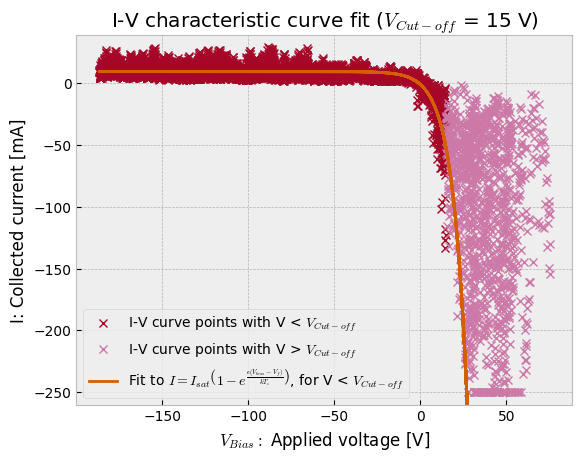

Ion saturation current [mA] = 9.184729476706567 ± 0.9700950851485259%
Floating potential [V] = -0.9831766626982609 ± -26.316603796785227%
Electron temperature [K] = 97304.40552656815 ± 2.031733860837436%
C_s = 40079.65726097782 m/s
n_e = 4.7677186880130115e+20 m**(-3)


<Figure size 640x480 with 0 Axes>

In [9]:
# Defining constants:
e = 1.602177e-19     # Electron charge.    [This ('e' and 'k') leads to overflow (if introduced directly in fitting formula)!
k = 1.380649e-23     # Boltzmann constant.  Keep this in mind!]
m_i = 1.67262192e-27 # Ion mass (In our case of a hydrogen plasma, this is equal to the proton mass!)
A = 6e-6             # Probe area

# Fit data and plot
cut_off = 15
indices = (V_data_d < cut_off)
V_data_d_Cut = V_data_d[indices]
I_data_d_Cut = I_data_d[indices]

V_data_d_Not_Considered = V_data_d[~indices]
I_data_d_Not_Considered = I_data_d[~indices]

def func(V_Bias, I_Sat, V_f, T_ef): # T_ef = T_e*(k/e)
    return I_Sat * (1 - np.exp((V_Bias - V_f)/(T_ef)))
parameters, covariance = curve_fit(func, V_data_d_Cut, I_data_d_Cut)
plt.plot(V_data_d_Cut, I_data_d_Cut, 'x',
label=r'I-V curve points with V < $V_{Cut-off}$',
color = 'C1')
plt.plot(V_data_d_Not_Considered, I_data_d_Not_Considered,'x',
label=r'I-V curve points with V > $V_{Cut-off}$',
color = 'C5')
plt.plot(V_data_d, func(V_data_d, *parameters),
label=r'Fit to $I=I_{s a t}\left(1-e^{\frac{e\left(V_{b i a s}-V_f\right)}{k T_e}}\right)$, for V < $V_{Cut-off}$',
color = 'C4')

plt.ylim([min(I_data_d) - 10, max(I_data_d) + 10])

plt.title(r'I-V characteristic curve fit ($V_{Cut-off}$' + f' = {cut_off} V)')
plt.xlabel(r'$V_{Bias}:$ Applied voltage [V]')
plt.ylabel(r'I: Collected current [mA]')
plt.grid(True)
plt.legend(loc = 'best')
# plt.savefig('TestFig1.svg', format = 'svg')
plt.show()
plt.clf()
# plt.close() # Useful when dealing with widgets instead...

# Computing standard deviations of fitted parameter values:
perr = np.sqrt(np.diag(covariance))

# I fitted to T_ef = T_e*(k/e), so T_e = T_ef*(e/k). Transforming back:
parameters[2] = parameters[2]*e/k
perr[2] = perr[2]*e/k

# Printing fit results:
parameter_names = ['Ion saturation current [mA]','Floating potential [V]','Electron temperature [K]']
for count, parameter in enumerate(parameter_names):
    print(f'{parameter} = {parameters[count]} ± {perr[count]/parameters[count]*100}%')

# Printing other results: Missing uncertainties here.
C_s = np.sqrt((2*k*parameters[2])/(m_i))
print(f'C_s = {C_s} m/s')
print(f'n_e = {parameters[0]/(0.5*e*A*C_s)} m**(-3)')

# Debugging:
# print(max(V_data_d_Cut))
# print(max(V_data_d))

# Labels:
# parameters[0] -> I_Sat
# parameters[1] -> V_f
# parameters[2] -> T_e

In [10]:
def Plasma_Params(V_cutoff):

    """
    Input: Cut-off voltage.
    Output: 'params' vector:
        - params[0] -> I_Sat
        - params[1] -> V_f
        - params[2] -> T_e
        - params[3] -> C_s
        - params[4] -> n_e
    """

    indices = (V_data_d < V_cutoff)
    V_data_d_Cut = V_data_d[indices]
    I_data_d_Cut = I_data_d[indices]
    
    # Defining fitting function and fitting:
    def func(V_Bias, I_Sat, V_f, T_ef): # T_ef = T_e*(k/e)
        return I_Sat * (1 - np.exp((V_Bias - V_f)/(T_ef)))
    parameters, covariance = curve_fit(func, V_data_d_Cut, I_data_d_Cut)
    
    # Computing standard deviations of fitted parameter values:
    perr = np.sqrt(np.diag(covariance))
    
    # I fitted to T_ef = T_e*(k/e), so T_e = T_ef*(e/k). Transforming back:
    parameters[2] = parameters[2]*e/k
    perr[2] = perr[2]*e/k
    
    # Other results: Missing uncertainties here.
    C_s = np.sqrt((2*k*parameters[2])/(m_i))
    n_e = parameters[0]/(0.5*e*A*C_s)
    
    params = np.array([parameters[0], parameters[1], parameters[2], C_s, n_e])
    
    return(params, perr/params[:3]*100)

In [11]:
# Defining cut-off voltages sweep:
V_Cutoff_Sweep = np.linspace(0, 70, 1000)

y = []
yerr = []

# Computing plasma parameters (and their uncertainties) for each value of the cut-off voltage (in the sweep):
for x in V_Cutoff_Sweep:
    y.append(Plasma_Params(x)[0])
    yerr.append(Plasma_Params(x)[1])

In [12]:
# Values obtained for multiple cut-off voltages:
# Values:
I_Sat_list = [arr[0] for arr in y]
V_f_list   = [arr[1] for arr in y]
T_e_list   = [arr[2] for arr in y]
C_s_list   = [arr[3] for arr in y]
n_e_list   = [arr[4] for arr in y]

# Uncertainties:
I_Sat_err_list = [arr[0] for arr in yerr]
V_f_err_list   = [arr[1] for arr in yerr]
T_e_err_list   = [arr[2] for arr in yerr]
# C_s_err_list   = [arr[3] for arr in yerr] # These 2 aren't implemented yet!
# n_e_err_list   = [arr[4] for arr in yerr]

# Debugging:
# print(I_Sat_list)
# print(V_f_list)
# print(T_e_list)  
# print(C_s_list)  
# print(n_e_list)  

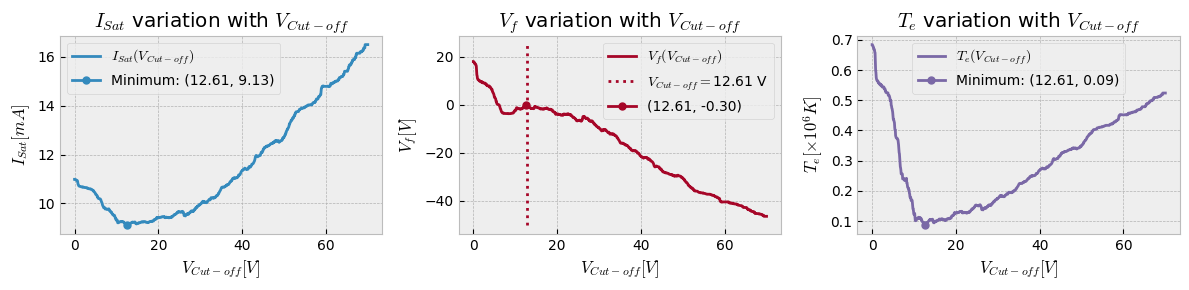

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

# For values:
axes[0].plot(V_Cutoff_Sweep, I_Sat_list, 'C0-', label=r'$I_{Sat}(V_{Cut-off})$')
axes[0].plot(V_Cutoff_Sweep[np.argwhere(I_Sat_list == min(I_Sat_list))], min(I_Sat_list), marker="o", markersize=5,
label = f'Minimum: ({V_Cutoff_Sweep[np.argwhere(I_Sat_list == min(I_Sat_list))][0][0]:.2f}, {min(I_Sat_list):.2f})') # Minimum point!
axes[0].set_xlabel(r'$V_{Cut-off} [V]$')
axes[0].set_ylabel(r'$I_{Sat} [mA]$')
axes[0].set_title(r'$I_{Sat}$ variation with $V_{Cut-off}$')
axes[0].legend()

axes[1].plot(V_Cutoff_Sweep, V_f_list, 'C1-',   label=r'$V_{f}(V_{Cut-off})$')
axes[1].vlines(12.73, -50, 25, linestyle = 'dotted', color = 'C1',
label = r'$V_{Cut-off} = $' + f'{V_Cutoff_Sweep[np.argwhere(I_Sat_list == min(I_Sat_list))][0][0]:.2f} V')
axes[1].plot(V_Cutoff_Sweep[np.argwhere(T_e_list == min(T_e_list))], V_f_list[np.argwhere(T_e_list == min(T_e_list))[0][0]],
marker = 'o', markersize = 5, color = 'C1',
label = f'({V_Cutoff_Sweep[np.argwhere(T_e_list == min(T_e_list))][0][0]:.2f}, {V_f_list[np.argwhere(T_e_list == min(T_e_list))[0][0]]:.2f})')
axes[1].set_xlabel(r'$V_{Cut-off} [V]$')
axes[1].set_ylabel(r'$V_{f} [V]$')
axes[1].set_title(r'$V_{f}$ variation with $V_{Cut-off}$')
axes[1].legend()

axes[2].plot(V_Cutoff_Sweep, np.array(T_e_list)*1e-6, 'C2-',   label=r'$T_{e}(V_{Cut-off})$')
axes[2].plot(V_Cutoff_Sweep[np.argwhere(T_e_list == min(T_e_list))], min(T_e_list)*1e-6, marker="o", markersize=5,
label = f'Minimum: ({V_Cutoff_Sweep[np.argwhere(T_e_list == min(T_e_list))][0][0]:.2f}, {min(T_e_list)*1e-6:.2f})', color = 'C2') # Minimum point!
axes[2].set_xlabel(r'$V_{Cut-off} [V]$')
axes[2].set_ylabel(r'$T_{e} [\times 10^{6} K]$')
axes[2].set_title(r'$T_{e}$ variation with $V_{Cut-off}$')
axes[2].legend()

fig.tight_layout()

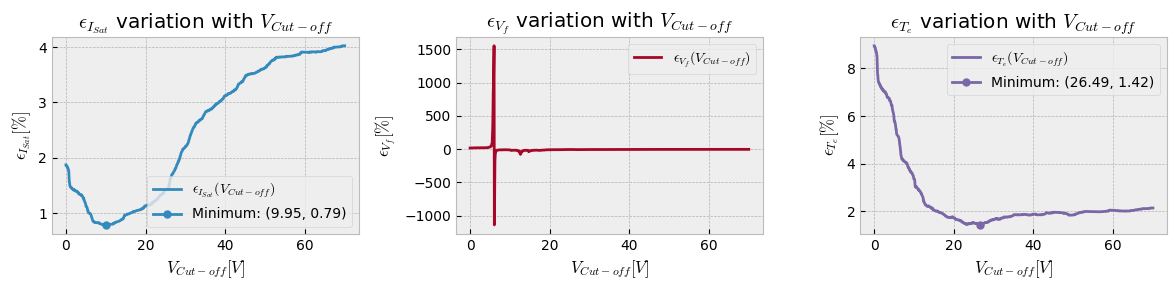

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

# For values' uncertainties:
axes[0].plot(V_Cutoff_Sweep, I_Sat_err_list, 'C0-', label=r'$\epsilon_{I_{Sat}}(V_{Cut-off})$')
axes[0].plot(V_Cutoff_Sweep[np.argwhere(I_Sat_err_list == min(I_Sat_err_list))[0]], min(I_Sat_err_list), marker="o", markersize=5,
label = f'Minimum: ({V_Cutoff_Sweep[np.argwhere(I_Sat_err_list == min(I_Sat_err_list))][0][0]:.2f}, {min(I_Sat_err_list):.2f})',
color = 'C0') # 'np.argwhere(I_Sat_err_list == min(I_Sat_err_list))[0]' I put a '[0]' here, since there were more than 1 minimum value.
axes[0].set_xlabel(r'$V_{Cut-off} [V]$')
axes[0].set_ylabel(r'$\epsilon_{I_{Sat}} [\%]$')
axes[0].set_title(r'$\epsilon_{I_{Sat}}$ variation with $V_{Cut-off}$')
axes[0].legend()

axes[1].plot(V_Cutoff_Sweep, V_f_err_list, 'C1-',   label=r'$\epsilon_{V_{f}}(V_{Cut-off})$')
axes[1].set_xlabel(r'$V_{Cut-off} [V]$')
axes[1].set_ylabel(r'$\epsilon_{V_{f}} [\%]$')
axes[1].set_title(r'$\epsilon_{V_{f}}$ variation with $V_{Cut-off}$')
axes[1].legend()

axes[2].plot(V_Cutoff_Sweep, np.array(T_e_err_list), 'C2-',   label=r'$\epsilon_{T_{e}}(V_{Cut-off})$')
axes[2].plot(V_Cutoff_Sweep[np.argwhere(T_e_err_list == min(T_e_err_list))], min(T_e_err_list), marker="o", markersize=5,
label = f'Minimum: ({V_Cutoff_Sweep[np.argwhere(T_e_err_list == min(T_e_err_list))][0][0]:.2f}, {min(T_e_err_list):.2f})',
color = 'C2')
axes[2].set_xlabel(r'$V_{Cut-off} [V]$')
axes[2].set_ylabel(r'$\epsilon_{T_{e}} [\%]$')
axes[2].set_title(r'$\epsilon_{T_{e}}$ variation with $V_{Cut-off}$')
axes[2].legend()

fig.tight_layout()
# Note that as V_f approaches 0, the relative uncertainty explodes! I shall not consider this graph to infer stuff.

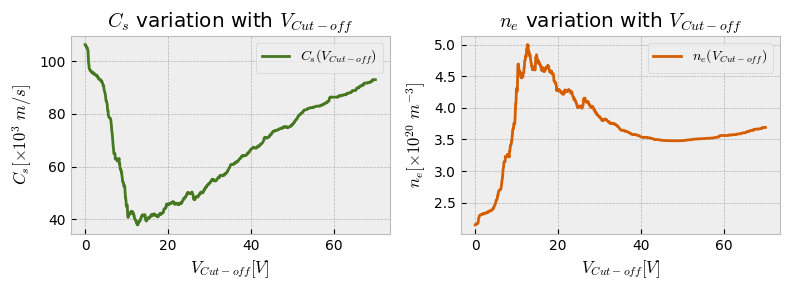

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

axes[0].plot(V_Cutoff_Sweep, np.array(C_s_list)*1e-3, 'C3-',   label=r'$C_{s}(V_{Cut-off})$')
axes[0].set_xlabel(r'$V_{Cut-off} [V]$')
axes[0].set_ylabel(r'$C_{s} [\times 10^{3}$ $m/s]$')
axes[0].set_title(r'$C_{s}$ variation with $V_{Cut-off}$')
axes[0].legend()

axes[1].plot(V_Cutoff_Sweep, np.array(n_e_list)*1e-20, 'C4-',   label=r'$n_{e}(V_{Cut-off})$')
axes[1].set_xlabel(r'$V_{Cut-off} [V]$')
axes[1].set_ylabel(r'$n_{e} [\times 10^{20}$ $m^{-3}]$')
axes[1].set_title(r'$n_{e}$ variation with $V_{Cut-off}$')
axes[1].legend()

fig.tight_layout()

## **$2^{nd}$ Part:**

Temporal evolution of the plasma parameters along one plasma cycle, ~25 ms (data in
**Table 2**, although data in table 1 may also be used). 

<center>

|shot ID|collected current ID|applied voltage|
|-----|-----------|-----------|
|35604|CHANNEL_030|CHANNEL_026|
|35605|CHANNEL_029|CHANNEL_026|
|36891|CHANNEL_028|CHANNEL_029|
|36891|CHANNEL_026|CHANNEL_029|

**Table 2:** Data for the temporal evolution analysis.

</center>

In [16]:
# Load and select data
shot = 35604
client = StartSdas()
V_data, time = LoadSdasData(client, 'PCIE_ATCA_ADC_16.BOARD_1.CHANNEL_026', shot)
I_data, _ = LoadSdasData(client, 'PCIE_ATCA_ADC_16.BOARD_1.CHANNEL_030', shot)

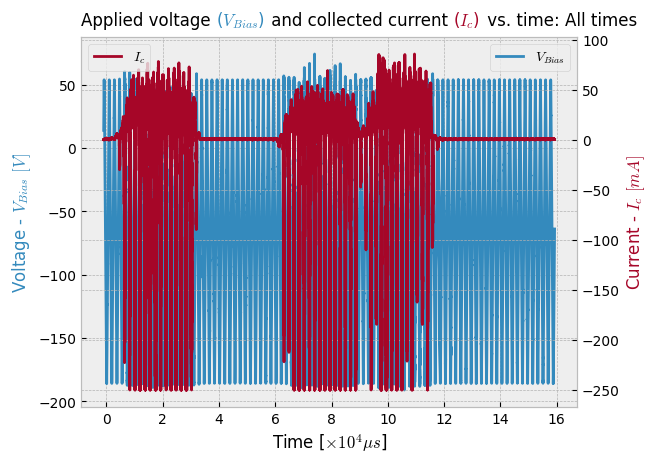

<Figure size 640x480 with 0 Axes>

In [17]:
# "Interactive" plots: Change 'inline' to 'widget'
%matplotlib inline

# Getting to know our data:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(time*1e-4, V_data, 'C0-', label=r'$V_{Bias}$')
ax2.plot(time*1e-4, I_data, 'C1-', label=r'$I_c$')

ax1.set_xlabel(r'Time [$\times 10^{4}\mu s$]')
ax1.set_ylabel(r'Voltage - $V_{Bias}$ $[V]$', color='C0')
ax2.set_ylabel(r'Current - $I_c$ $[mA]$', color='C1')

label_list = ['Applied voltage ', r'($V_{Bias}$) ', ' and collected current ', r'($I_c$) ', ' vs. time: All times']
colors = ['black', 'C0', 'black', 'C1', 'black']
color_title(label_list, colors)

plt.grid(True)
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
# plt.savefig('TestFig1.svg', format = 'svg')
plt.show()
plt.clf()
# plt.close() # Useful when dealing with widgets...
# Here, the 3 cycles are visible.

In [90]:
# Selecting a time interval:
bool_indices = (time > 3500) & (time < 33500.5) # Considering only the 1st cycle (~30 ms)
V_data_d = V_data[bool_indices]
I_data_d = I_data[bool_indices]
time_d = time[bool_indices]

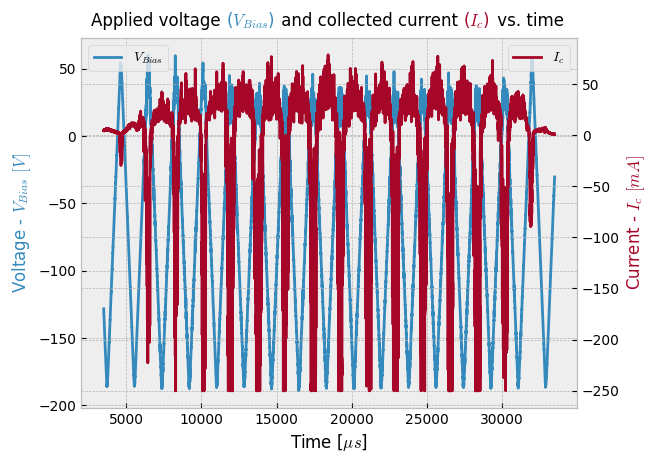

<Figure size 640x480 with 0 Axes>

In [91]:
# Plotting the selected time interval:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(time_d, V_data_d, 'C0-', label=r'$V_{Bias}$')
ax2.plot(time_d, I_data_d, 'C1-', label=r'$I_c$')

ax1.set_xlabel(r'Time [$\mu s$]')
ax1.set_ylabel(r'Voltage - $V_{Bias}$ $[V]$', color='C0')
ax2.set_ylabel(r'Current - $I_c$ $[mA]$', color='C1')

label_list = ['Applied voltage ', r'($V_{Bias}$) ', ' and collected current ', r'($I_c$) ', ' vs. time']
colors = ['black', 'C0', 'black', 'C1', 'black']
color_title(label_list, colors)

plt.grid(True)
ax1.legend(loc='upper left')
ax2.legend()
# plt.savefig('TestFig1.svg', format = 'svg')
plt.show()
plt.clf()
# plt.close() # Useful when dealing with widgets instead...

In [107]:
# Splitting np.array in 16 chunks, since we seem to have roughly 16 I-V characteristic curves.
print(len(V_data_d)) # Debugging: {split_j} must be a divisor of {len(V_data_d)} for 'split' to work!
split_j = 16
V_d = np.split(V_data_d, split_j)
I_d = np.split(I_data_d, split_j)
t_d = np.split(time_d, split_j)

60000


In [ ]:
# Plotting the selected time interval:
for i in range(0, split_j):
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(t_d[i], V_d[i], 'C0-', label=r'$V_{Bias}$')
    ax2.plot(t_d[i], I_d[i], 'C1-', label=r'$I_c$')

    ax1.set_xlabel(r'Time [$\mu s$]')
    ax1.set_ylabel(r'Voltage - $V_{Bias}$ $[V]$', color='C0')
    ax2.set_ylabel(r'Current - $I_c$ $[mA]$', color='C1')

    label_list = ['Applied voltage ', r'($V_{Bias}$) ', ' and collected current ', r'($I_c$) ', ' vs. time']
    colors = ['black', 'C0', 'black', 'C1', 'black']
    color_title(label_list, colors)

    plt.grid(True)
    ax1.legend(loc='upper left')
    ax2.legend()
    # plt.savefig('TestFig1.svg', format = 'svg')
    plt.show()
    plt.clf()
    # plt.close() # Useful when dealing with widgets instead...

In [273]:
from uncertainties import ufloat

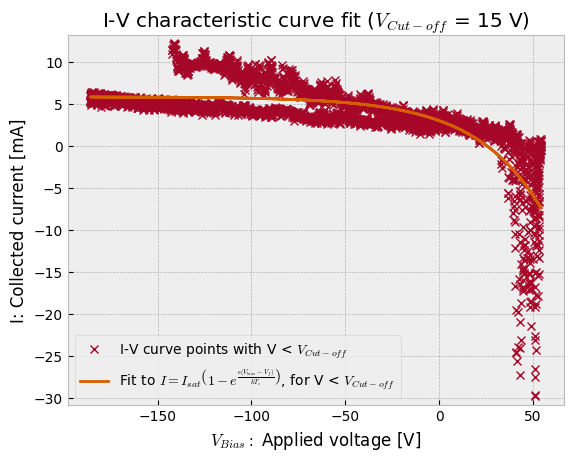

Ion saturation current [mA] = 5.81174152545542 ± 1.1533424283355844%
Floating potential [V] = 25.341482715943904 ± 2.222467411848644%
Electron temperature [K] = 407930.93545385427 ± 3.042340747242839%
C_s = 82063.69503988323 m/s
n_e = 1.4734095333106706e+20 m**(-3)


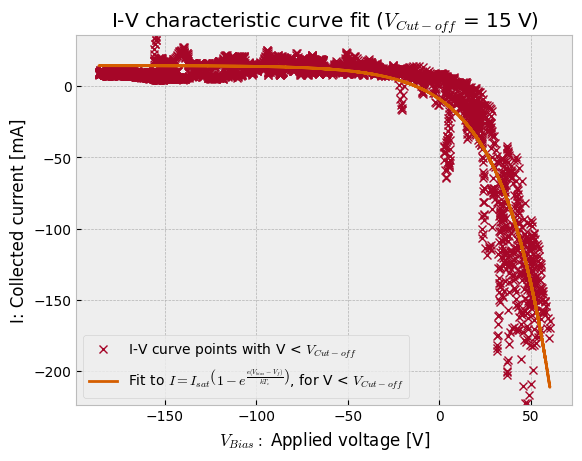

Ion saturation current [mA] = 14.590034148912867 ± 2.400022873841324%
Floating potential [V] = -12.768417176305546 ± -5.360419100253356%
Electron temperature [K] = 309182.66588394524 ± 1.3388517905976383%
C_s = 71443.9266514147 m/s
n_e = 4.248731091302734e+20 m**(-3)


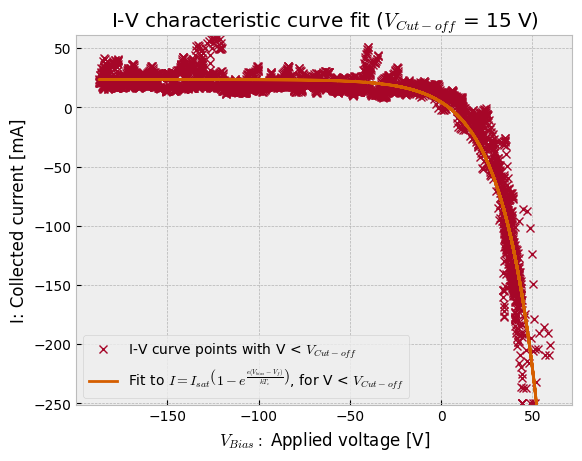

Ion saturation current [mA] = 23.569644707526955 ± 1.2500669718678974%
Floating potential [V] = 4.210272148912999 ± 8.23690714811863%
Electron temperature [K] = 227711.55720169246 ± 1.025444074054277%
C_s = 61312.67775127486 m/s
n_e = 7.997808561708344e+20 m**(-3)


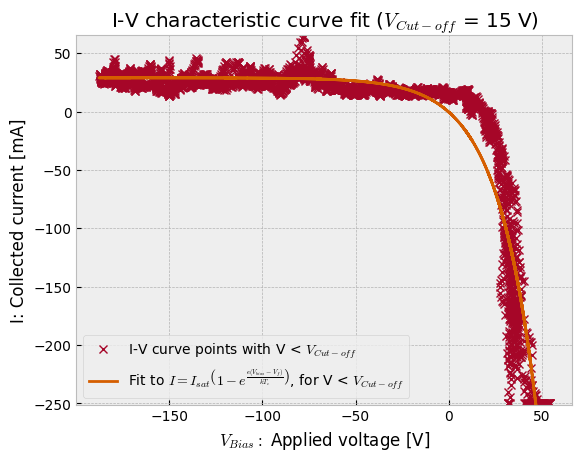

Ion saturation current [mA] = 28.976424707325776 ± 1.5351910222339789%
Floating potential [V] = -0.2820134743410533 ± -145.09226701488163%
Electron temperature [K] = 240317.44094426243 ± 1.103943355729866%
C_s = 62986.92293553272 m/s
n_e = 9.571117729023033e+20 m**(-3)


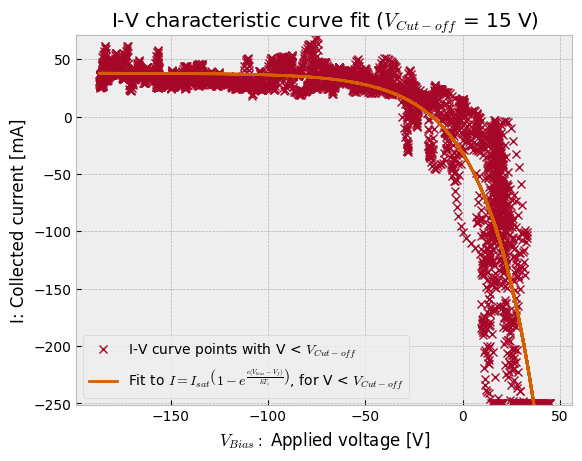

Ion saturation current [mA] = 37.84774418084119 ± 1.961588096392824%
Floating potential [V] = -15.644058637367158 ± -3.865040873625689%
Electron temperature [K] = 298648.30456203356 ± 1.6801350915926279%
C_s = 70216.27301362107 m/s
n_e = 1.1214256308897403e+21 m**(-3)


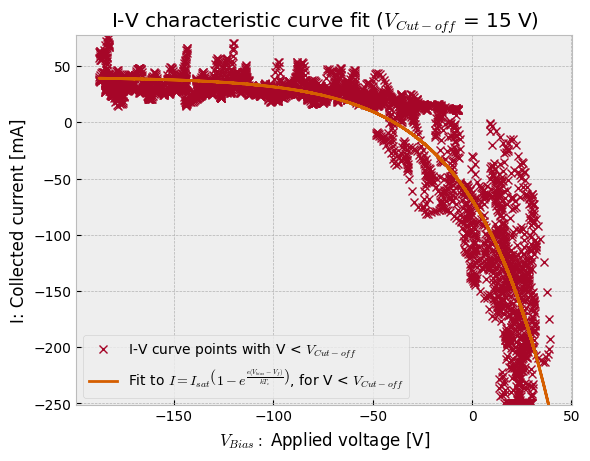

Ion saturation current [mA] = 40.05421660485794 ± 2.2953587508837954%
Floating potential [V] = -39.35947744434412 ± -2.08376184609573%
Electron temperature [K] = 455464.5543231279 ± 1.8954331280342975%
C_s = 86713.16525990589 m/s
n_e = 9.6101785140624e+20 m**(-3)


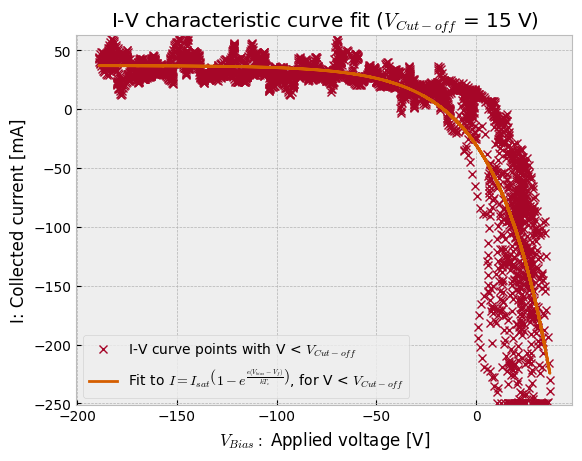

Ion saturation current [mA] = 37.13430601831587 ± 2.12143101440194%
Floating potential [V] = -16.31092806110396 ± -4.684942392929326%
Electron temperature [K] = 316896.39655516885 ± 2.3065979652280006%
C_s = 72329.65566630084 m/s
n_e = 1.0681375106136457e+21 m**(-3)


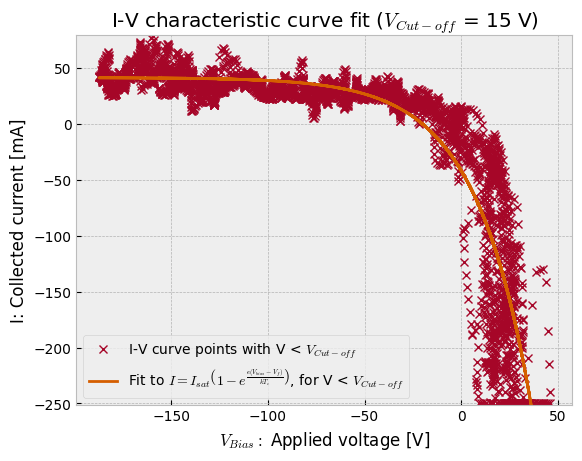

Ion saturation current [mA] = 41.23310060653152 ± 1.977990830889871%
Floating potential [V] = -20.125815698178535 ± -3.286766589078036%
Electron temperature [K] = 333583.8368010208 ± 1.787230755734726%
C_s = 74209.62669913426 m/s
n_e = 1.1559897920739376e+21 m**(-3)


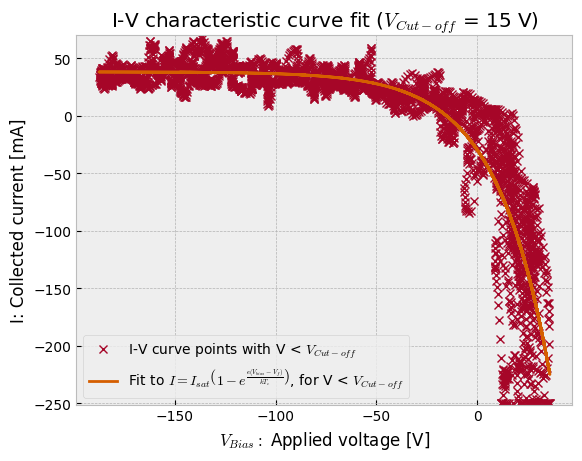

Ion saturation current [mA] = 38.261005640031996 ± 1.8849728423702476%
Floating potential [V] = -15.135226883076713 ± -4.319412368267563%
Electron temperature [K] = 308464.85345220484 ± 1.996999567353093%
C_s = 71360.94473745927 m/s
n_e = 1.115485789536065e+21 m**(-3)


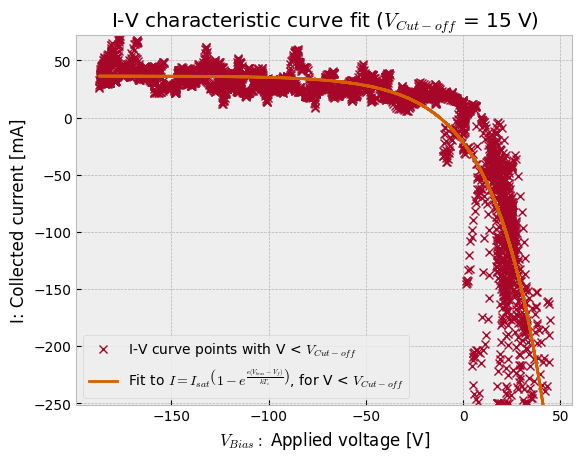

Ion saturation current [mA] = 36.382773737339555 ± 1.7057302616133645%
Floating potential [V] = -12.112587711080566 ± -4.724380173744097%
Electron temperature [K] = 298432.5783561181 ± 1.7538948472927272%
C_s = 70190.90835166801 m/s
n_e = 1.0784082340274232e+21 m**(-3)


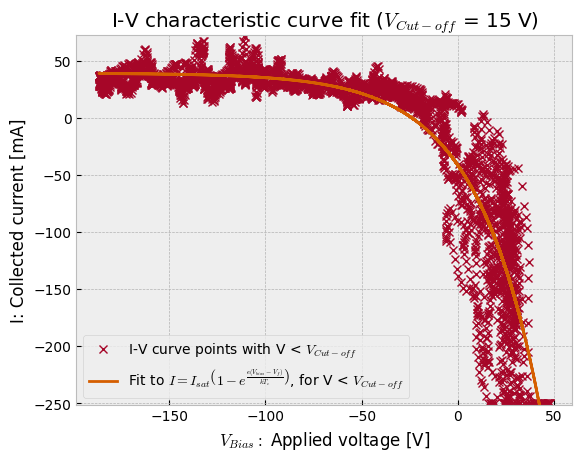

Ion saturation current [mA] = 39.35394562875779 ± 1.934909089132109%
Floating potential [V] = -23.75751156489591 ± -2.9312023432751944%
Electron temperature [K] = 383994.5189548275 ± 1.7969930644634278%
C_s = 79619.64921848314 m/s
n_e = 1.0283389216006305e+21 m**(-3)


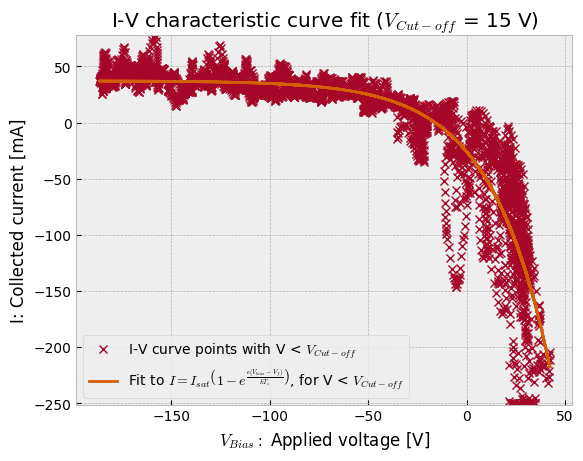

Ion saturation current [mA] = 37.16301350303381 ± 1.735457098655959%
Floating potential [V] = -15.99354169084881 ± -4.129309446409295%
Electron temperature [K] = 351095.0192596511 ± 1.939329842797987%
C_s = 76132.49829025447 m/s
n_e = 1.0155682012078264e+21 m**(-3)


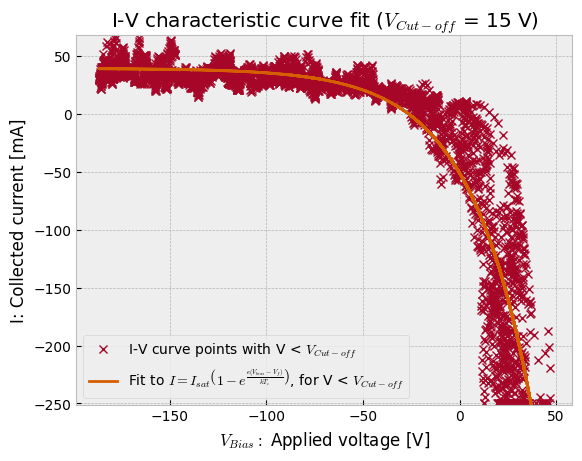

Ion saturation current [mA] = 39.61468434741226 ± 2.1525292931992226%
Floating potential [V] = -26.163262125251805 ± -2.7555068253828017%
Electron temperature [K] = 368390.5196756289 ± 1.7561424877125036%
C_s = 77985.16041784929 m/s
n_e = 1.0568478841728325e+21 m**(-3)


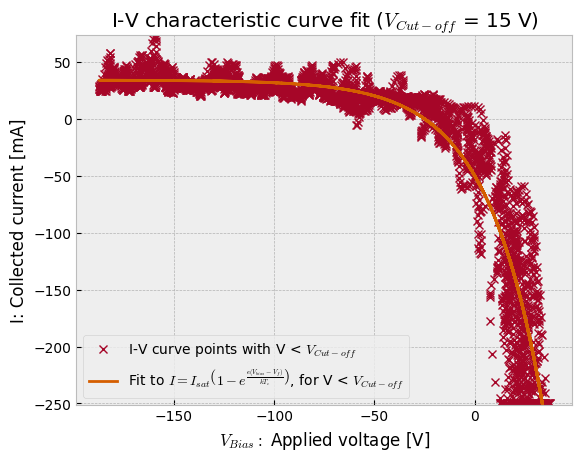

Ion saturation current [mA] = 34.24898640023721 ± 1.9485041684414957%
Floating potential [V] = -24.78743739839514 ± -2.424885638224115%
Electron temperature [K] = 321198.8020887072 ± 1.5051691579579698%
C_s = 72818.99916464854 m/s
n_e = 9.785235219197075e+20 m**(-3)


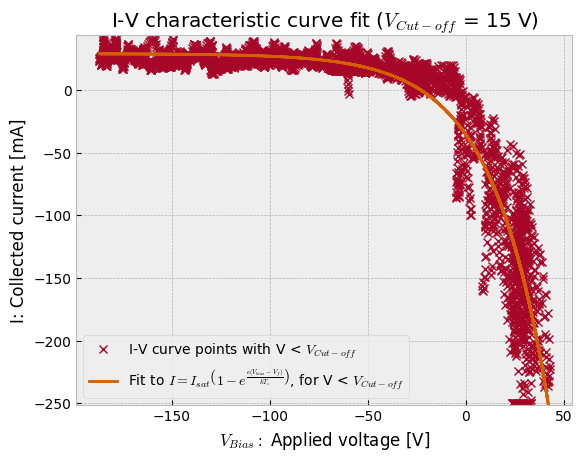

Ion saturation current [mA] = 28.78219355699913 ± 1.8708181457282629%
Floating potential [V] = -23.047188384216874 ± -2.565341746844165%
Electron temperature [K] = 333106.676262652 ± 1.4112806108995724%
C_s = 74156.53273410119 m/s
n_e = 8.07500362668585e+20 m**(-3)


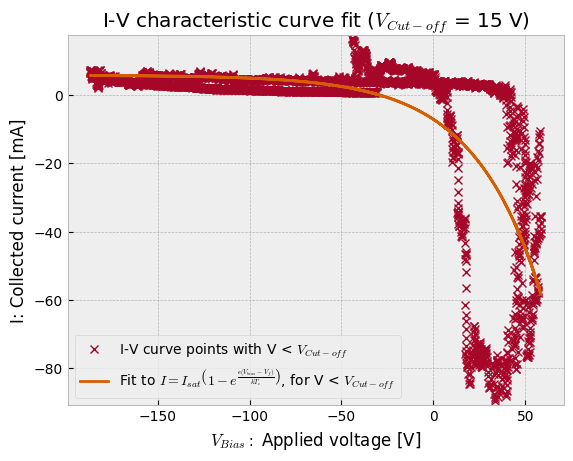

Ion saturation current [mA] = 5.766980843709291 ± 6.767705770536492%
Floating potential [V] = -29.39267989991449 ± -7.121610463718349%
Electron temperature [K] = 423475.40658864734 ± 3.7535944133775194%
C_s = 83612.62226286177 m/s
n_e = 1.4349769237991124e+20 m**(-3)


<Figure size 640x480 with 0 Axes>

In [339]:
T_e_Time = []
T_e_Time_Epsilon = []
n_e_Time = []
n_e_Time_Epsilon = []
V_f_Time = []
V_f_Time_Epsilon = []
V_p_Time = []

for j in range(0, split_j):
    # Note that cut-off voltage was not considered for this analysis!
    # It should, but this would just make things more complicated. Results are fine this way...
    # Fit data and plot:
    def func(V_Bias, I_Sat, V_f, T_ef): # T_ef = T_e*(k/e)
        return I_Sat * (1 - np.exp((V_Bias - V_f)/(T_ef)))
    parameters, covariance = curve_fit(func, V_d[j], I_d[j])
    plt.plot(V_d[j], I_d[j], 'x',
    label=r'I-V curve points with V < $V_{Cut-off}$',
    color = 'C1')
    plt.plot(V_d[j], func(V_d[j], *parameters),
    label=r'Fit to $I=I_{s a t}\left(1-e^{\frac{e\left(V_{b i a s}-V_f\right)}{k T_e}}\right)$, for V < $V_{Cut-off}$',
    color = 'C4')

    plt.ylim([min(I_d[j]) - 1, max(I_d[j]) + 1])

    plt.title(r'I-V characteristic curve fit ($V_{Cut-off}$' + f' = {cut_off} V)')
    plt.xlabel(r'$V_{Bias}:$ Applied voltage [V]')
    plt.ylabel(r'I: Collected current [mA]')
    plt.grid(True)
    plt.legend(loc = 'best')
    # plt.savefig('TestFig1.svg', format = 'svg')
    plt.show()
    plt.clf()
    # plt.close() # Useful when dealing with widgets instead...

    # Computing standard deviations of fitted parameter values:
    perr = np.sqrt(np.diag(covariance))

    # I fitted to T_ef = T_e*(k/e), so T_e = T_ef*(e/k). Transforming back:
    parameters[2] = parameters[2]*e/k
    perr[2] = perr[2]*e/k

    # Printing fit results:
    parameter_names = ['Ion saturation current [mA]','Floating potential [V]','Electron temperature [K]']
    for count, parameter in enumerate(parameter_names):
        print(f'{parameter} = {parameters[count]} ± {perr[count]/parameters[count]*100}%')

    # Printing other results: Missing uncertainties here.
    C_s = np.sqrt((2*k*parameters[2])/(m_i))
    print(f'C_s = {C_s} m/s')
    print(f'n_e = {parameters[0]/(0.5*e*A*C_s)} m**(-3)')

    T_e_Time.append(parameters[2])
    T_e_Time_Epsilon.append(perr[2])

    n_e_Time.append(parameters[0]/(0.5*e*A*C_s))

    V_f_Time.append(parameters[1])
    V_f_Time_Epsilon.append(perr[1])

    n_e_ufloat= ufloat(parameters[0], perr[0]) # This should be I_Sat, but it's correct, because it's also wrong ahead...
    T_e_ufloat = ufloat(parameters[2], perr[2])
    C_s_ufloat = ((2*k*T_e_ufloat)/(m_i))**(1/2)
    n_e_Time_Epsilon.append(n_e_ufloat/(0.5*e*A*C_s_ufloat))

    V_f_ufloat = ufloat(parameters[1], perr[1])
    V_p_Time.append(V_f_ufloat + 3*k*T_e_ufloat/e)

In [302]:
labels = []
delta = t_d[0][-1] - t_d[0][0]
for i in range(0, split_j):
    labels.append(f'[{(t_d[0][0] + delta*i + 0.5*i)/1000:.2f}, {(t_d[0][0] + delta*(i+1) + 0.5*i)/1000:.2f}]')

print(f'Labels = {labels}') # Debugging!

Labels = ['[3.50, 5.38]', '[5.38, 7.25]', '[7.25, 9.12]', '[9.13, 11.00]', '[11.00, 12.88]', '[12.88, 14.75]', '[14.75, 16.62]', '[16.63, 18.50]', '[18.50, 20.38]', '[20.38, 22.25]', '[22.25, 24.12]', '[24.13, 26.00]', '[26.00, 27.88]', '[27.88, 29.75]', '[29.75, 31.62]', '[31.63, 33.50]']


In [303]:
import pandas as pd

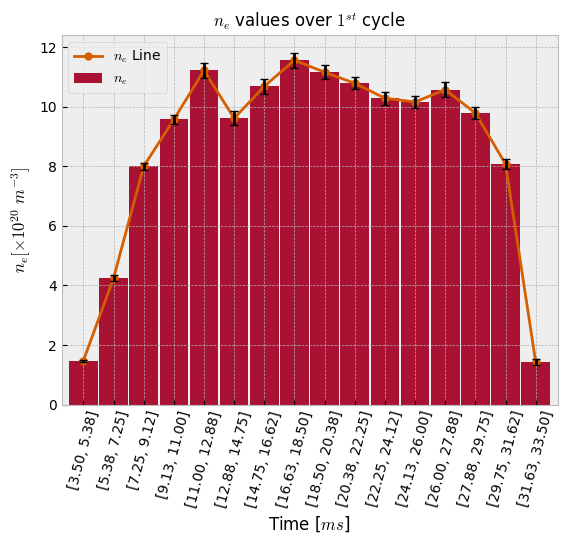

In [351]:
df = pd.DataFrame(dict(data=np.array(n_e_Time)/1e20))

fig, ax = plt.subplots()

df['data'].plot(kind='line', marker='.', color='C4', ms=10, label = r'$n_{e}$ Line')
df['data'].plot(kind='bar', color='C1', alpha = 0.95, width = 0.95, label = r'$n_{e}$',
yerr=[val.s/1e20 for val in n_e_Time_Epsilon], capsize=3)
plt.title(r'$n_{e}$ values over $1^{st}$ cycle', fontsize=12)
plt.xlabel(r'Time [$ms$]')
plt.xticks(np.arange(len(x)), labels=tuple(labels), rotation=75)
plt.ylabel(r'$n_{e} [\times 10^{20}$ $m^{-3}]$')
plt.legend()
plt.show()

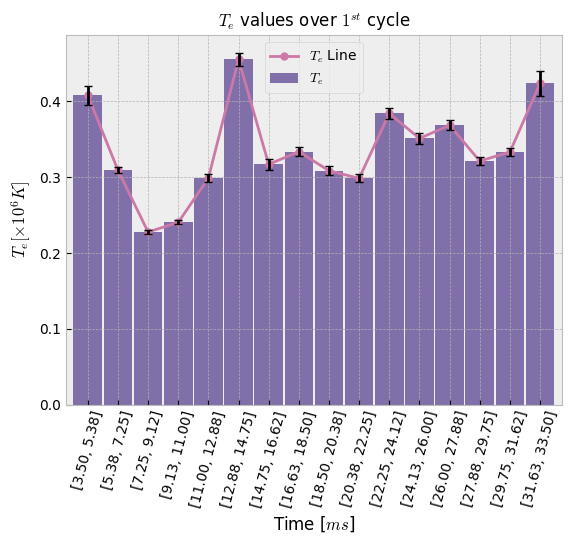

In [352]:
df = pd.DataFrame(dict(data=np.array(T_e_Time)/1e6))

fig, ax = plt.subplots()

df['data'].plot(kind='line', marker='.', color='C5', ms=10, label = r'$T_{e}$ Line')
df['data'].plot(kind='bar', color='C2', alpha = 0.95, width = 0.95, label = r'$T_{e}$',
yerr=np.array(T_e_Time_Epsilon)/1e6, capsize=3)
plt.title(r'$T_{e}$ values over $1^{st}$ cycle', fontsize=12)
plt.xlabel(r'Time [$ms$]')
plt.xticks(np.arange(len(x)), labels=tuple(labels), rotation=75)
plt.ylabel(r'$T_{e} [\times 10^{6} K]$')
plt.legend()
plt.show()

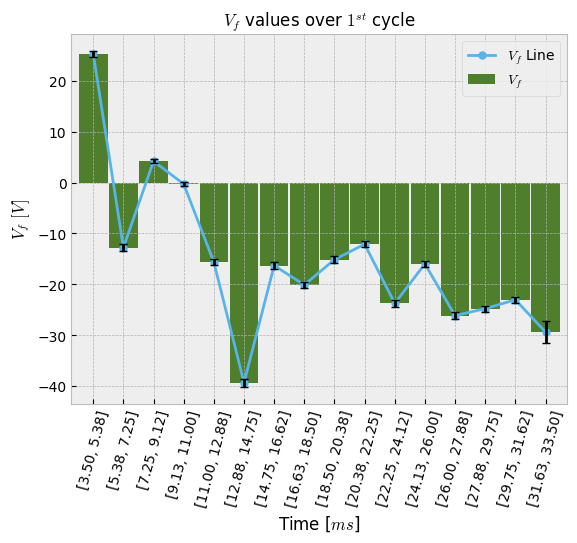

In [353]:
df = pd.DataFrame(dict(data=np.array(V_f_Time)))

fig, ax = plt.subplots()

df['data'].plot(kind='line', marker='.', color='C6', ms=10, label = r'$V_{f}$ Line')
df['data'].plot(kind='bar', color='C3', alpha = 0.95, width = 0.95, label = r'$V_{f}$',
yerr=np.array(V_f_Time_Epsilon), capsize=3)
plt.title(r'$V_{f}$ values over $1^{st}$ cycle', fontsize=12)
plt.xlabel(r'Time [$ms$]')
plt.xticks(np.arange(len(x)), labels=tuple(labels), rotation=75)
plt.ylabel(r'$V_{f}$ $[V]$')
plt.legend()
plt.show()

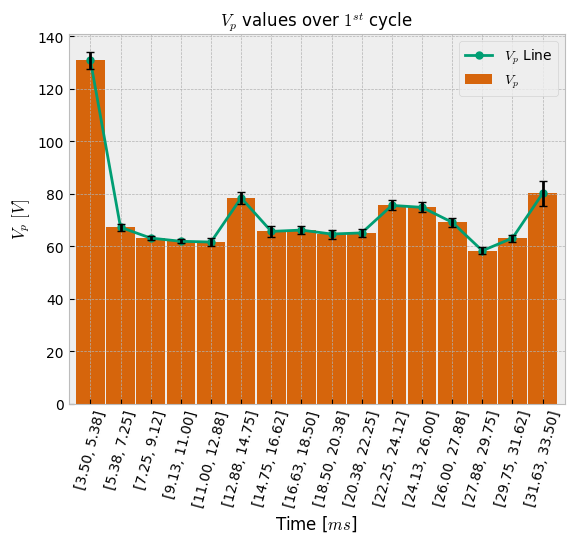

In [360]:
df = pd.DataFrame(dict(data=np.array([val.n for val in V_p_Time])))

fig, ax = plt.subplots()

df['data'].plot(kind='line', marker='.', color='C7', ms=10, label = r'$V_{p}$ Line')
df['data'].plot(kind='bar', color='C4', alpha = 0.95, width = 0.95, label = r'$V_{p}$',
yerr=[val.s for val in V_p_Time], capsize=3)
plt.title(r'$V_{p}$ values over $1^{st}$ cycle', fontsize=12)
plt.xlabel(r'Time [$ms$]')
plt.xticks(np.arange(len(x)), labels=tuple(labels), rotation=75)
plt.ylabel(r'$V_{p}$ $[V]$')
plt.legend()
plt.show()